# Description of notebook

This notebook includes the code for the solution of the main task. The notebook is structured after *Task 1: Replicate figure 1* and *Task 2: Replicate figure 3 and 4* from the EFT paper.

In [2]:
# Standard libraries
import sys
from time import time

# Third party
import emcee 
import corner
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

## Task 1: Replicate figure 1

Replicate figure 1 by using emcee to sample the parameter space for a flat prior and a naturaleness prior. Note that the cells include unit tests for the defined functions.

In [3]:
def load_data(file):
    '''Load data given 'file' into a dictionary'''
    d = {
        "x": [],
        "d": [],
        "sigma": []
    }
    # Skip first two rows, which are the header:
    with open(file) as f:
        for idx,line in enumerate(f):
            if idx < 3:
                pass
            else:
                val = line.split()
                d["x"].append(np.float(val[0]))
                d["d"].append(np.float(val[1]))
                d["sigma"].append(np.float(val[2]))
    # Cast to numpy arrays
    d["x"] = np.array(d["x"])
    d["d"] = np.array(d["d"])
    d["sigma"] = np.array(d["sigma"])
    return d


file = 'D1_c_5.dat'
data = load_data(file)
display(data)

{'x': array([0.03183, 0.06366, 0.09549, 0.12732, 0.15915, 0.19099, 0.22282,
        0.25465, 0.28648, 0.31831]),
 'd': array([0.31694, 0.33844, 0.42142, 0.57709, 0.56218, 0.68851, 0.73625,
        0.8727 , 1.0015 , 1.0684 ]),
 'sigma': array([0.01585 , 0.01692 , 0.02107 , 0.02885 , 0.02811 , 0.03443 ,
        0.03681 , 0.04364 , 0.050075, 0.05342 ])}

Define uniform prior and naturaleness prior. Naturaleness prior means that the constants $\{a_i\}$ are constrained to be of order one. The naturaleness prior is defined as

$$ pr(a|\bar{a}, I) = \left( \frac{1}{\sqrt{2 \pi} \bar{a}} \right)^{\text{len}(a)} \exp\left({\frac{-a^2}{2 \bar{a}^2}}\right).$$

Note that $a$ is a vector, so $a^2 = a\cdot a$. The log of this prior is

$$ \log{pr(a|\bar{a}, I)} = -\text{len}(a) \sqrt{2 \pi} \bar{a} - \frac{1}{2}\frac{a^2}{\bar{a}^2}.$$

Hence we implement the priors as follows.

In [18]:
def log_uniform_prior(a):
    '''
    Uniform prior, returns a log(1) if the values in a are in abs(a)<100. Note that this
    prior is not normalized. We take care of this later.
    '''
    if np.all(np.abs(a)<=100):
        return 0  # log(1)
    else: 
        return -np.inf  # log(0)
    

def log_naturalness_prior(a, bar_a=5):
    '''Naturaleness prior implemented according to equation 24 with bar(a)=5. This ensures'''
    return -len(a)*np.log(np.sqrt(2*np.pi)*bar_a) - 1/2*(a.dot(a)/bar_a**2)

# Apply unit tests
test1 = log_uniform_prior([-1,2,50]) == 0
test2 = log_uniform_prior([-1,2,500]) == -np.inf
test3 = -7.8651 == np.round(np.log((1/(np.sqrt(2*np.pi)*5))**3 * \
        np.exp(-(1+4+9)/(2*5**2))),4) == np.round(log_naturalness_prior(np.array([1,2,3]), 5),4) # Calculate expression exact and log
                          
print(f'Passed test 1: {test1}')
print(f'Passed test 2: {test2}')
print(f'Passed test 3: {test3}')

Passed test 1: True
Passed test 2: True
Passed test 3: True


Construct likelihood function. According to Sec. I in the referenced paper, the available data is fitted with Gaussian noise. No error is specified for the points $\{x_j\}$ at which the points have been sampled:

$$ d_j = g(x_j)(1+c\eta_j),$$
where $\eta_j$ is normally distributed with mean zero and standard deviation 1, and $c$ is a relative error. Our likelihood can then be written as (eq. 29):

$$ pr(D|a,I) = \prod_{j=1}^{N_d} \left(\frac{1}{\sqrt{2 \pi} \sigma_{j, exp}} \right) e^{-\chi^2/2} \rightarrow$$

$$ \log(pr(D|a,I) = - \sum_{j=1}^{N_d} \left(\log(\sqrt{2 \pi}\sigma_{j,exp})\right)  - \frac{\chi^2}{2}  ,$$
where $N_d$ is the number of datapoints, $\sigma_{j,exp}$ is the standard deviation for data point $d_j$. The $\chi^2$ measure is given by: 

$$ \chi^2 = \sum_{i=1}^{N_d} \left(\frac{d_i - g(x_i)}{\sigma_i} \right)^2$$

This we implement in the following functions.

In [19]:
def true_function(x):
    '''The true model underlining the data'''
    return (0.5 + np.tan(np.pi/2 * x))**2


def simple_model(a, x):
    '''Returns model of order 3. a is a vector containing the model parameters.'''
    return a[0] + a[1]*x + a[2]*x**2 + a[3]*x**3


def chi_squared(a, d, x, sigmas):
    '''
    Returns the chi squared measure for the datapoints d and x. The standard deviation is 
    assumed to be constant for all datapoints.
    '''
    chi_vec = (d-simple_model(a, x))/sigmas
    return np.sum(chi_vec**2)


def log_likelihood(a, d, x, sigmas):
    '''
    Returns log likelihood based on a Gaussian with di as the center values and 
    a standard deviation of sigma. a is the feature vector for our model.
    '''
    chi_sq = chi_squared(a,d,x,sigmas)
    like = -np.sum(np.log(np.sqrt(2*np.pi)*sigmas)) - 1/2*chi_sq
    return like


# Unit tests
a = np.array([1,2,3,4])
x = np.array([1,2])
d = np.array([2,4])
sigmas = np.array([2,4])
test1 = [10, 49] == simple_model(a,x)
test2 = 142.5625==chi_squared(a,d,x,sigmas)
exact_likelihood = np.prod(1/(np.sqrt(2*np.pi)*sigmas)) * np.exp(-chi_squared(a,d,x,sigmas)/2)
test_likelihood = np.round(log_likelihood(np.array([1,2,3,4]), np.array([2,4]), np.array([1,2]), np.array([2,4])),4)
test3 = np.round(np.log(exact_likelihood),4) == np.round(test_likelihood, 4) # exact calculation, and then log
print(f'Passed test 1: {test1}')
print(f'Passed test 2: {test2}')
print(f'Passed test 3: {test3}')

Passed test 1: [ True  True]
Passed test 2: True
Passed test 3: True


Define log of posterior as sum of log prior and log likelihood. Note that we don't normalize our posterior at the moment - we will do that numerically later.

In [20]:
def log_post_uniform(a,d,x,sigma):
    '''The log posterior corresponding to the uniform prior'''
    return log_likelihood(a,d,x,sigma) + log_uniform_prior(a)


def log_post_natural(a,d,x,sigma, bar_a):
    '''The log posterior corresponding to the naturalness prior'''
    return log_likelihood(a,d,x,sigma) + log_naturalness_prior(a, bar_a=bar_a)

Sample the parameter space using MCMC sampling (emcee). Our model has three degrees of freedom as of now. 

In [22]:
# Define constants and data
bar_a = 5
x = data["x"]
d = data["d"]
sigma = data["sigma"]

# Define dimensions and walkers
ndim = 4  # k = kmax = 3: a0, a1, a2, a3
nwalkers = 10
# Initial guess
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))


nburn = 200  # number of burn-in steps
nsamples = 10000  # number of final samples 

# Additional arguments to our sampler: d, x, sigma and d, x, sigma, bar_a respectively
arglist_uniform = (d, x, sigma)
arglist_natural = (d, x, sigma, bar_a)

# Define samplers
sampler_uniform = emcee.EnsembleSampler(nwalkers, ndim, log_post_uniform, args=arglist_uniform)
sampler_natural = emcee.EnsembleSampler(nwalkers, ndim, log_post_natural, args=arglist_natural)
# Start sampler on posteriors. Use first few hundred iterations as burn-in. 
t0 = time()  # Start time
sampler_uniform.run_mcmc(p0, nburn + nsamples)
sampler_natural.run_mcmc(p0, nburn + nsamples)
t1 = time()  # End time
print(f'Sampling time: {(t1-t0):.1f} seconds.') # Format string with round

# Extract the samples and ignore burn in. Reshape to a single matrix
samples_uniform = sampler_uniform.chain[:,nburn:,:].reshape((-1,ndim))  # Reshape to all samples per dim
sampler_natural = sampler_natural.chain[:,nburn:,:].reshape((-1,ndim)) 

Sampling time: 31.655 seconds.


Plot the results using Corner.

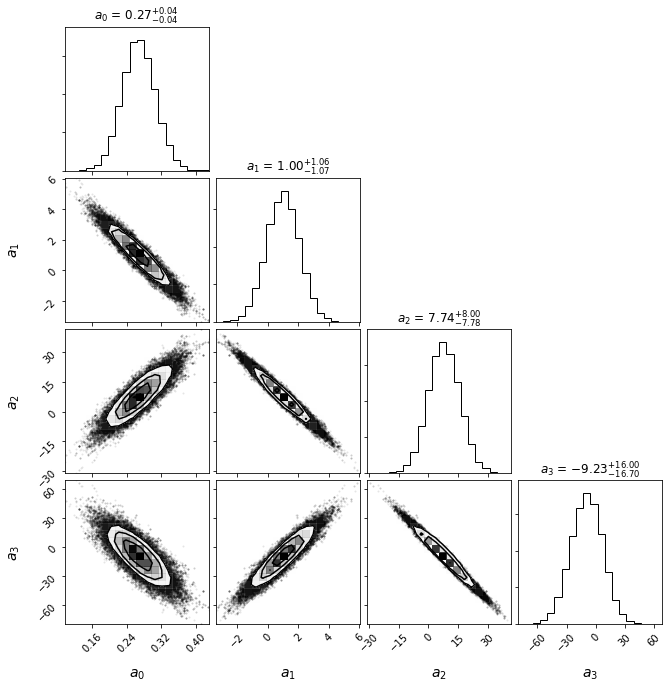

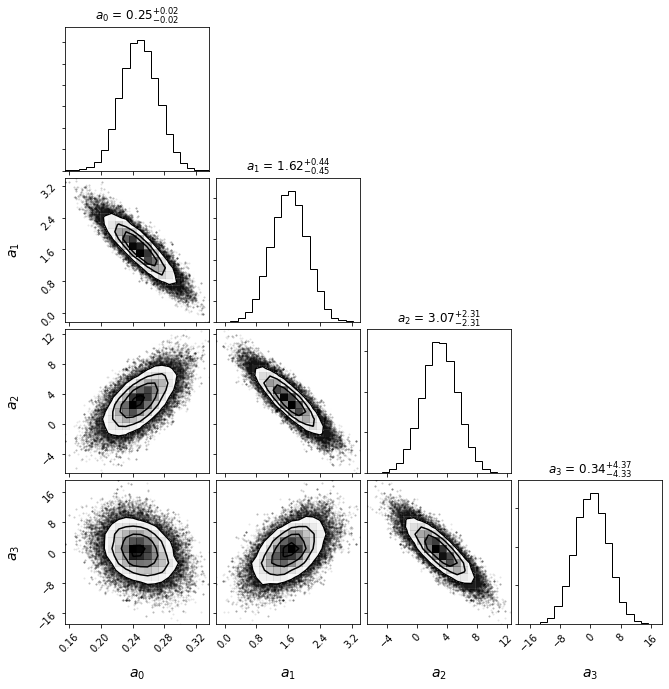

In [24]:
# Plot the marginalized chain using corner
fig_uniform = corner.corner(samples_uniform, labels=[r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"],
                            label_kwargs={"fontsize":14},
                           show_titles=True, title_kwargs={"fontsize": 12})
fig_uniform.savefig("corner_uniform")

fig_natural = corner.corner(sampler_natural, labels=[r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"],
                            label_kwargs={"fontsize":14},
                           show_titles=True, title_kwargs={"fontsize": 12})
fig_natural.savefig("corner_natural")

## Task 2. Replicate figure 3 and 4

In [25]:
def evaluate_model(x, a, dob=0.68):
    '''
    Returns the predicted mean and DoB interval for the models.
    The model's parameters are; 
    x: the postions to evaluate the functions on,
    a: the samples model weights
    dob: the Degree of belief
    '''
    # Create the corresponding desing matrix
    x = x.reshape(-1,1)
    X_d = np.concatenate((x**0, x**1, x**2, x**3), axis=1)
    X_d = X_d.swapaxes(0,1) # Swap axes to use matrix multiplication
    
    # Evaluate the model, calcualte the mean and calculate the bounds of the DoB intervals
    y = a @ X_d
    y_mean = np.mean(y, axis=0)
    y_lower, y_upper = DoB_interval(y, dob)
    
    return y, y_mean, y_lower, y_upper

def DoB_interval(y, dob):
    '''
    Calculate the Degree of Belief interval based on the assumption of a unimodal distribution.
    More specific, it minimizes the length of a 'dob' large density interval to find the highest density interval.
    '''
    y = np.sort(y, axis=0)
    number_of_index_for_dob = int(0.68*y.shape[0])
    lower_bound = np.zeros(y.shape[1])
    upper_bound = np.zeros(y.shape[1])
    for j in tqdm(range(y.shape[1])):
        width = np.inf
        save_index = 0
        for i in range(y.shape[0]-number_of_index_for_dob):
            ymin = y[i,j]
            ymax = y[i+number_of_index_for_dob,j]
            if ymax-ymin < width:
                save_index = i
                width = ymax - ymin
        lower_bound[j] = y[save_index,j]
        upper_bound[j] = y[save_index+number_of_index_for_dob,j]
    
    return lower_bound, upper_bound

In [26]:
# Create data to evaluate model on from 0 to 0.4
xmin = 0.0
xmax = 0.4
step = 0.001
interval = np.arange(xmin, xmax, step).reshape((-1,1))

# Evaluate the model based on the uniform prior
y_uniform, y_mean_uniform, y_lower_uniform, y_upper_uniform = evaluate_model(interval, samples_uniform)

# Evaluate the model based on the naturalness prior
y_natural, y_mean_natural, y_lower_natural, y_upper_natural = evaluate_model(interval, sampler_natural)

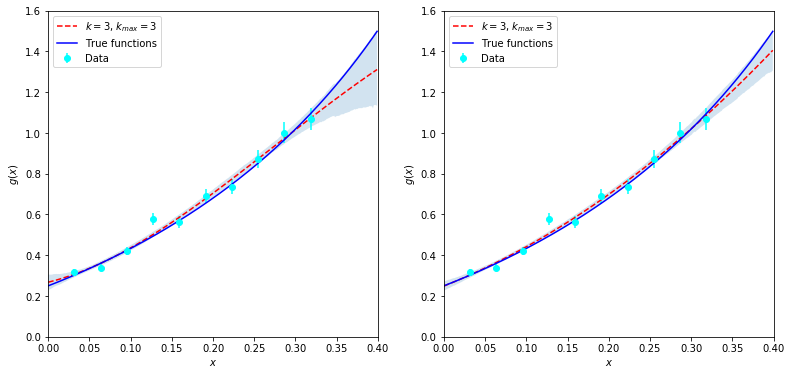

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))

# Plot the evaluation of the model based on the uniform prior
ax1.plot(interval, y_mean_uniform, color='red', linestyle='--', label=r'$k=3$, $k_{max}=3$')
ax1.fill_between(interval[:,0], y_lower_uniform, y_upper_uniform, alpha=0.2)
ax1.plot(interval, true_function(interval), color='blue', label='True functions')
ax1.errorbar(x, d, yerr=sigma, color='cyan', marker='o', linestyle='None', label='Data')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$g(x)$')
ax1.set_xlim(0, 0.4)
ax1.set_ylim(0, 1.6)
ax1.legend(loc='best')

# Plot the evaluation of the model based on the naturalness prior
ax2.plot(interval, y_mean_natural, color='red', linestyle='--', label=r'$k=3$, $k_{max}=3$')
ax2.fill_between(interval[:,0], y_lower_natural, y_upper_natural, alpha=0.2)
ax2.plot(interval, true_function(interval), color='blue', label='True functions')
ax2.errorbar(x, d, yerr=sigma, color='cyan', marker='o', linestyle='None', label='Data')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$g(x)$')
ax2.set_xlim(0, 0.4)
ax2.set_ylim(0, 1.6)
ax2.legend(loc='best')

plt.show()